In [1]:
# Import modules that contain functions we need
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import scipy
import scipy.integrate

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter
from matplotlib.animation import FuncAnimation

%config InlineBackend.figure_format='retina' # makes animation display better


#%matplotlib qt 
# ^ UNCOMMENT THIS LINE IS USING WINDOWS

In [2]:
### http://balbuceosastropy.blogspot.com/2014/03/construction-of-hertzsprung-russell.html
### most of this code is heavily inspired/based from this person's code

In [3]:
filename = 'asu.tsv'
data = pd.read_table(filename, skiprows=44, sep=';', header=None, index_col=0,
                   names = ['HIP', 'Vmag', 'Plx', 'B-V', 'SpType'],
                   skipfooter=1, engine='python')

#removing all the nan stuff
data2 = data.applymap(lambda x: np.nan if isinstance(x, str) and x.isspace() else x)
data2 = data2.dropna()
data2.describe()

Vmag      Plx     B-V  SpType
count   114472   114472  114472  114472
unique    1072     5361    2426    4070
top       8.69     2.93   1.000      K0
freq       502      182     308    8537

In [4]:
data2['Vmag'] = data2['Vmag'].astype(np.float64)
data2['Plx'] = data2['Plx'].astype(np.float64)
data2['B-V'] = data2['B-V'].astype(np.float64)

#adding absolute magnitude column 
data2['M_V'] = data2['Vmag'] + 5 * np.log10(data2['Plx']/100.)

#adding luminosity
sun_lum = 3.86 * 10e26
data2['lum'] = sun_lum * 10 ** ((4.83 - data2['M_V'])/2.5)

#adding mass
data2['mass'] = data2['lum']**(2/7) 

data2

C:\Users\luvma\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\luvma\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Vmag    Plx    B-V SpType       M_V           lum          mass
HIP                                                                    
1       9.10   3.54  0.482     F5  1.845016  6.033659e+28  1.671179e+08
2       9.27  21.90  0.999    K3V  5.972221  1.348029e+27  5.640825e+07
3       6.61   2.81 -0.019     B9 -1.146468  9.488000e+29  3.672037e+08
4       8.06   7.75  0.370    F0V  2.506509  3.280831e+28  1.404184e+08
5       8.55   2.87  0.902  G8III  0.839409  1.523434e+29  2.177457e+08
...      ...    ...    ...    ...       ...           ...           ...
118318  6.99   1.92  1.595     K2 -1.593494  1.432138e+30  4.130434e+08
118319  8.23  10.63  0.639    G2V  3.362666  1.491148e+28  1.120927e+08
118320  7.59   5.00  0.999     K0  1.084850  1.215199e+29  2.041264e+08
118321  9.20  19.22  0.698    G5V  5.618767  1.866726e+27  6.190665e+07
118322  4.49   8.71 -0.075   B9IV -0.809909  6.959067e+29  3.360804e+08

[114472 rows x 7 columns]

In [5]:
# Rows that do not meet the condition alpha + num are eliminated
f = lambda s: (len(s) >= 2)  and (s[0].isalpha()) and (s[1].isdigit()) 
i  = data2['SpType'].apply(f)
data2 = data2[i]

# A new column is created with the first two characters from 'SpType'
f = lambda s: s[0:2]
data2['SpType2'] = data2['SpType'].apply(f)

# Only want OBAFGKM
f = lambda s: s[0] in 'OBAFGKM'
data2 = data2[data2['SpType'].map(f)]

# and then ordering them
orden = {'O':'0', 'B':'1', 'A':'2', 'F':'3', 'G':'4', 'K':'5', 'M':'6'}
f = lambda s: orden[s[0]]+s[1]
data2['SpType2'] = data2['SpType2'].apply(f)
data2.head()

<ipython-input-5-4e0d37891e65>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['SpType2'] = data2['SpType'].apply(f)


Vmag    Plx    B-V SpType       M_V           lum          mass SpType2
HIP                                                                         
1    9.10   3.54  0.482     F5  1.845016  6.033659e+28  1.671179e+08      35
2    9.27  21.90  0.999    K3V  5.972221  1.348029e+27  5.640825e+07      53
3    6.61   2.81 -0.019     B9 -1.146468  9.488000e+29  3.672037e+08      19
4    8.06   7.75  0.370    F0V  2.506509  3.280831e+28  1.404184e+08      30
5    8.55   2.87  0.902  G8III  0.839409  1.523434e+29  2.177457e+08      48

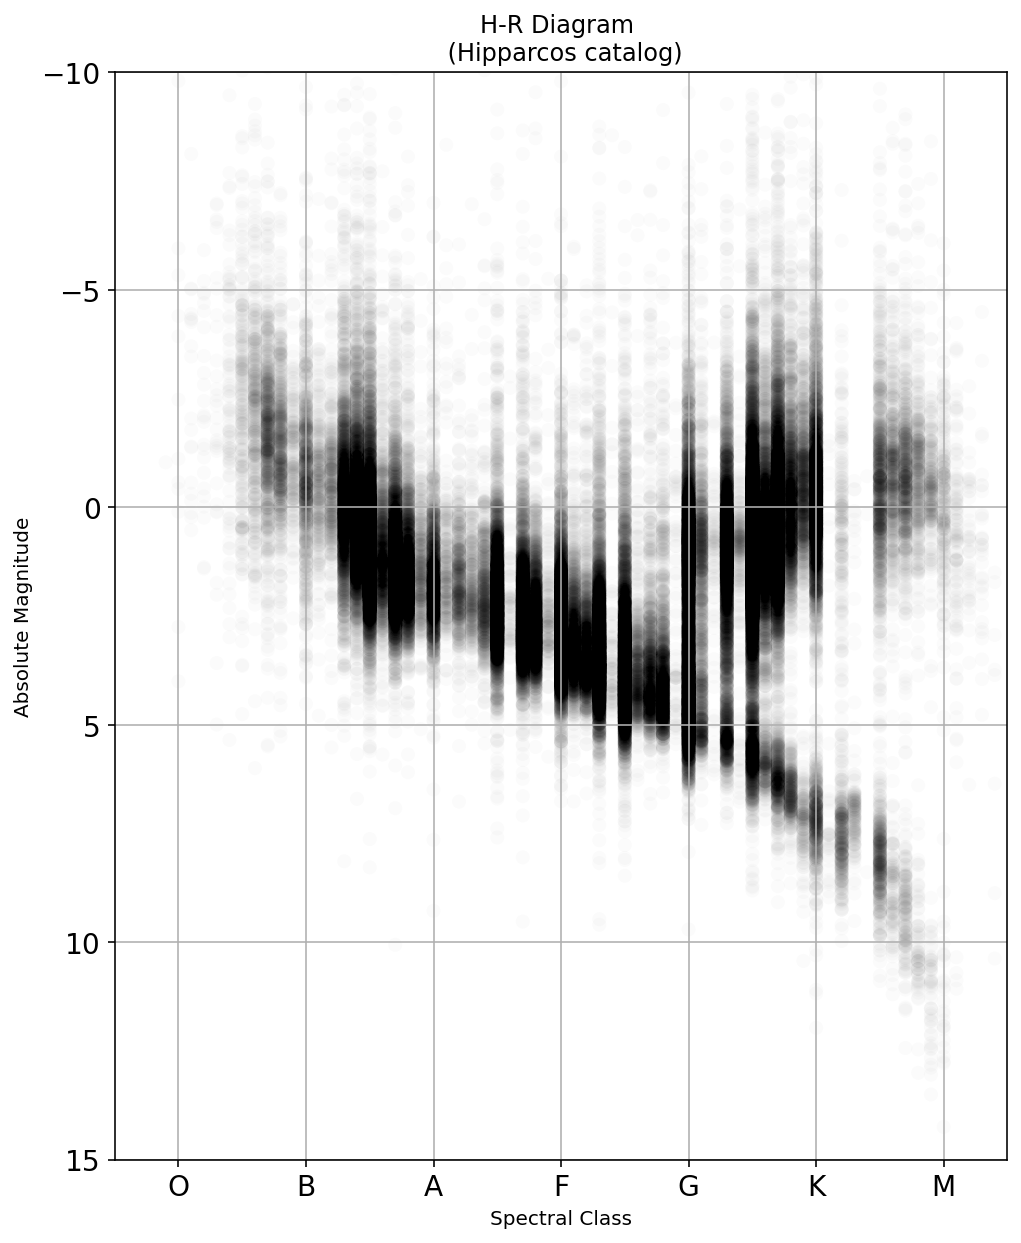

In [6]:
### Plotting on spectral class

fig, ax = plt.subplots(figsize=(8,10))

ax.set_xlim(0, 70)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.set_xlabel('Spectral Class')
ax.set_ylabel('Absolute Magnitude')

ax.scatter(data2['SpType2'].astype(np.int64), data2['M_V'],
           s=50, edgecolors='none', alpha=0.015, c='k')
ax.set_xticks(range(5,75,10))
ax.set_xticklabels(['O', 'B', 'A', 'F', 'G', 'K', 'M'])
ax.tick_params(axis='both', labelsize=14)

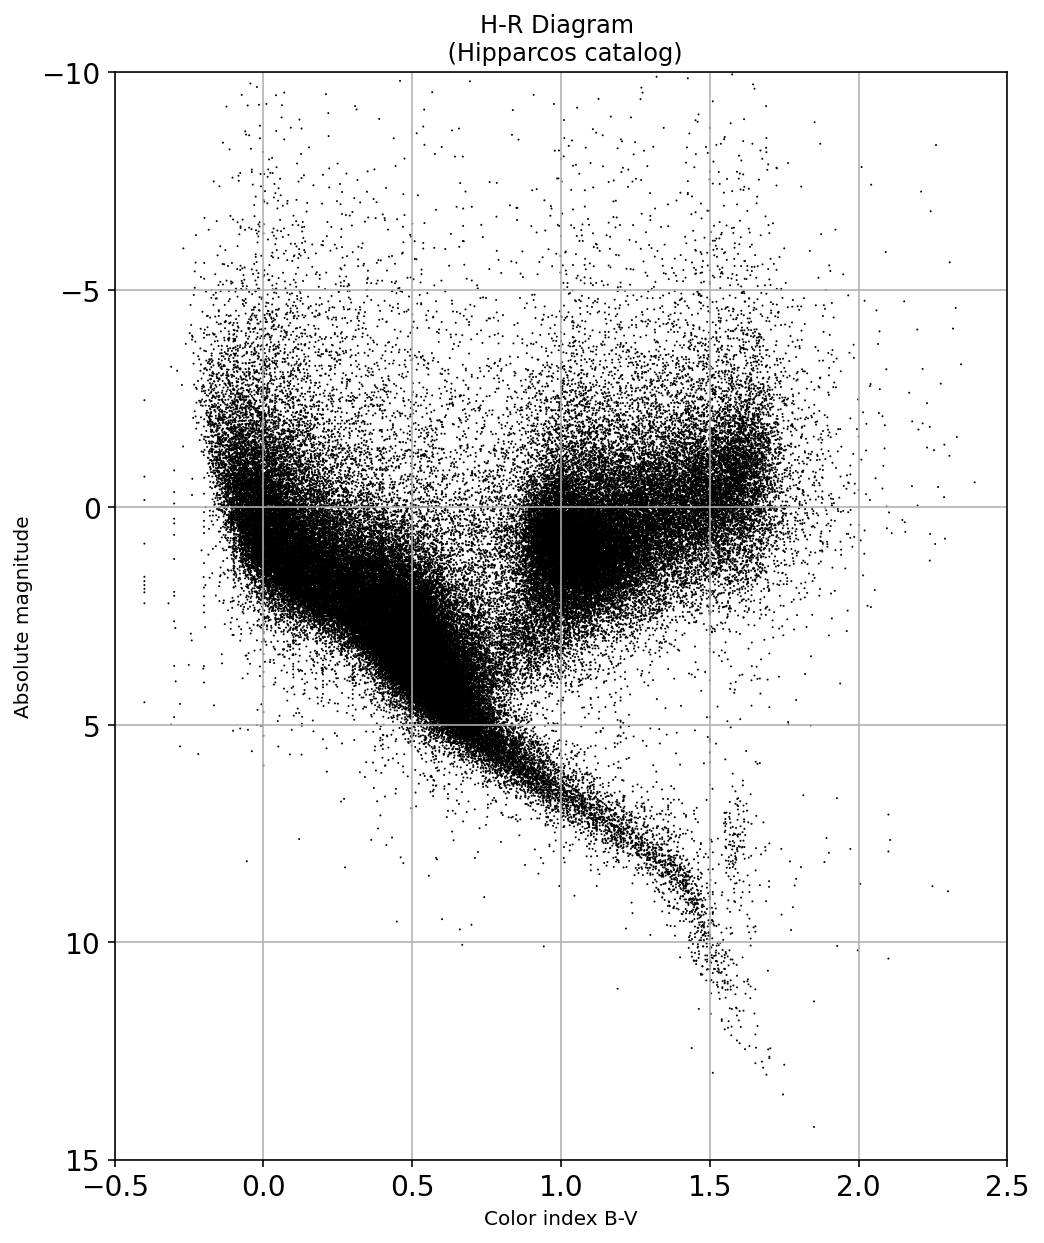

In [7]:
###

fig, ax = plt.subplots(figsize=(8,10))

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -10)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.set_xlabel('Color index B-V')
ax.set_ylabel('Absolute magnitude')

ax.scatter(data2['B-V'], data2['M_V'],
#           s=50, edgecolors='none', alpha=0.015, c='k')
           s=1, edgecolors='none', c='k')

ax.tick_params(axis='both', labelsize=14)

In [8]:
def classA(s):
    if 'VII' in s:
        return "Class VII: white dwarfs"
    elif ('VI' in s) and ('VII' not in s):
        return "Class VI: subdwarfs"
    elif ('V' in s) and ('VI' not in s) and ('IV' not in s):
        return "Class V: main-sequence"
    elif 'IV' in s:
        return "Class IV: subgiants"
    elif  ('II' in s) and ('III' not in s) and ('VII' not in s):
        return "Class III: giants"
    elif 'III' in s:
        return "Class II: bright giants"
    elif ('I' in s) and ('II' not in s) and ('V' not in s):
        return "Class I: supergiants"
    else:
        return np.nan
    
def color(s):
    if 'VII' in s:
        return "white"
    elif ('VI' in s) and ('VII' not in s):
        return "blue"
    elif ('V' in s) and ('VI' not in s) and ('IV' not in s):
        return "black"
    elif 'IV' in s:
        return "gray"
    elif  ('II' in s) and ('III' not in s) and ('VII' not in s):
        return "green"
    elif 'III' in s:
        return "orange"
    elif ('I' in s) and ('II' not in s) and ('V' not in s):
        return "yellow"
    else:
        return np.nan
data3 = data2
data3["class"] = data3["SpType"].apply(classA)
data3["color"] = data3["SpType"].apply(color)
data3 = data3.dropna()

data3


Vmag    Plx    B-V  SpType       M_V           lum          mass  \
HIP                                                                         
2        9.27  21.90  0.999     K3V  5.972221  1.348029e+27  5.640825e+07   
4        8.06   7.75  0.370     F0V  2.506509  3.280831e+28  1.404184e+08   
5        8.55   2.87  0.902   G8III  0.839409  1.523434e+29  2.177457e+08   
6       12.31  18.80  1.336    M0V:  8.680789  1.112427e+26  2.765616e+07   
10       8.59  10.76  0.489     F6V  3.749061  1.044631e+28  1.012553e+08   
...       ...    ...    ...     ...       ...           ...           ...   
118307   6.83   2.67  1.614  M2III: -1.037444  8.581531e+29  3.568183e+08   
118315   8.47   3.00  1.011   K0III  0.855606  1.500876e+29  2.168196e+08   
118319   8.23  10.63  0.639     G2V  3.362666  1.491148e+28  1.120927e+08   
118321   9.20  19.22  0.698     G5V  5.618767  1.866726e+27  6.190665e+07   
118322   4.49   8.71 -0.075    B9IV -0.809909  6.959067e+29  3.360804e+08   

       SpType2                    class   color  
HIP                                              
2           53   Class V: main-sequence   black  
4           30   Class V: main-sequence   black  
5           48  Class II: bright giants  orange  
6           60   Class V: main-sequence   black  
10          36   Class V: main-sequence   black  
...        ...                      ...     ...  
118307      62  Class II: bright giants  orange  
118315      50  Class II: bright giants  orange  
118319      42   Class V: main-sequence   black  
118321      45   Class V: main-sequence   black  
118322      19      Class IV: subgiants    gray  

[54361 rows x 10 columns]

In [9]:
f = lambda s: 'VII' in s
b = data2['SpType'].map(f)
print(data2['B-V'][b])

HIP
77982    1.108
Name: B-V, dtype: float64


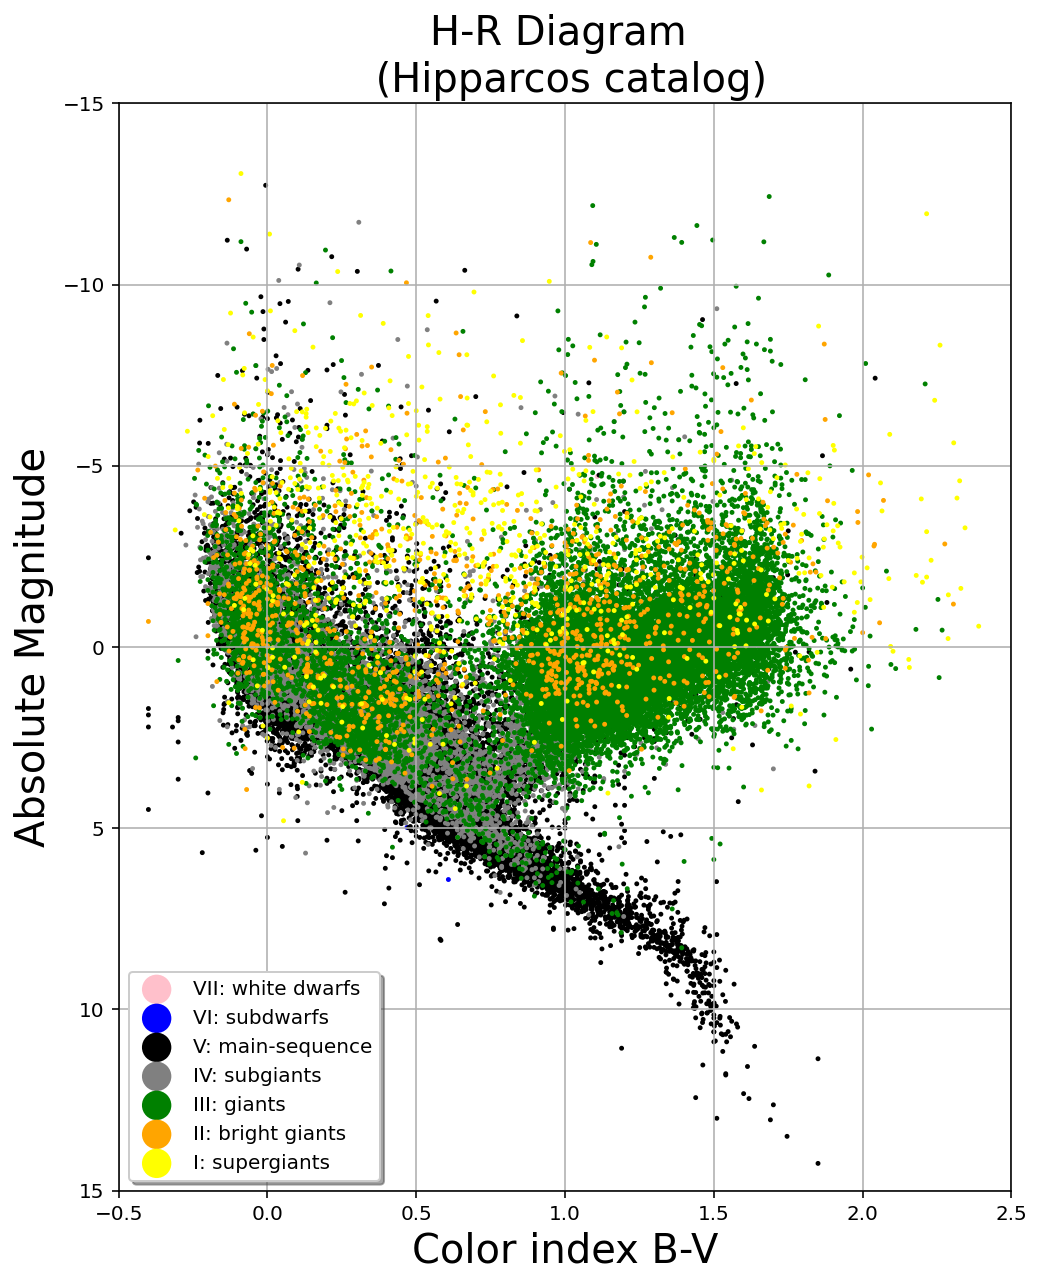

In [21]:
def plot_lum_class(b,c, label):
    ''' b: boolean Series to make the selection
        c: Color
        label: for the legend
    '''
    x = data2['B-V'][b]
    y = data2['M_V'][b]
    
 
    ax.scatter(x, y, c = c, s=6, edgecolors='none', label = label)

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.title.set_fontsize(20)
ax.set_xlabel('Color index B-V')
ax.xaxis.label.set_fontsize(20)
ax.set_ylabel('Absolute Magnitude')
ax.yaxis.label.set_fontsize(20)

f1 = lambda s: 'VII' in s
b = data2['SpType'].map(f1)
plot_lum_class(b,'pink', 'VII: white dwarfs')

f2 = lambda s: ('VI' in s) and ('VII' not in s)
b = data2['SpType'].map(f2)
plot_lum_class(b,'blue', 'VI: subdwarfs')

f3 = lambda s: ('V' in s) and ('VI' not in s) and ('IV' not in s)
b = data2['SpType'].map(f3)
plot_lum_class(b,'black', 'V: main-sequence')

f4 = lambda s: 'IV' in s
b = data2['SpType'].map(f4)
plot_lum_class(b,'grey', 'IV: subgiants')

f5 = lambda s: 'III' in s
b = data2['SpType'].map(f5)
plot_lum_class(b,'green', 'III: giants')

f6 = lambda s: ('II' in s) and ('III' not in s) and ('VII' not in s)
b = data2['SpType'].map(f6)
plot_lum_class(b,'orange', 'II: bright giants')

f7 = lambda s: ('I' in s) and ('II' not in s) and ('V' not in s)
b = data2['SpType'].map(f7)
plot_lum_class(b,'yellow', 'I: supergiants')

legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)


In [ ]:
data4 = data3[:5000]
data4 = data4.sort_values(by="lum", ascending=False)

b = data4['SpType'].map(f2)

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)

ax.set_xlim(-0.5, 2.5)
ax.set_ylim(15, -15)
ax.grid()
ax.set_title('H-R Diagram \n (Hipparcos catalog)')

ax.set_xlabel('Color Index B-V')
ax.set_ylabel('Absolute Magnitude')

ax.tick_params(axis='both', labelsize=14)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')



functions = [f1, f2, f3, f4, f5, f6, f7]

for f in functions:
    if f == f1:
        c = "pink"
        name = "VII: white dwarfs"
    elif f == f2:
        c = "blue"
        name = "VI: subdwarfs"
    elif f == f3:
        c = "black"
        name = "V: main-sequence"
    elif f == f4:
        c = "grey"
        name = "IV: subgiants"
    elif f == f5:
        c = "green"
        name = "III: giants"
    elif f == f6:
        c = "orange"
        name = "II: bright giants"
    elif f == f7:
        c = "yellow"
        name = "I: supergiants"
    
    plot_lum_class(data4["SpType"].map(f), c, name)
legend = ax.legend(scatterpoints=1,markerscale = 6, shadow=True)


In [14]:
data4

Vmag     Plx    B-V      SpType        M_V           lum  \
HIP                                                                
1466    7.63    0.00  0.267     B1II...       -inf           inf   
979     8.68    0.00  1.290       K2III       -inf           inf   
4050    7.82    0.01  1.093       K1III -12.180000  2.458031e+34   
8626    6.54    0.02  2.215  K5Ia0-a... -11.954850  1.997686e+34   
10676   8.77    0.01  1.496    K3/K4III -11.230000  1.024678e+34   
...      ...     ...    ...         ...        ...           ...   
439     8.56  229.33  1.462         M2V  10.362304  2.364098e+25   
8051   10.93   88.86  1.525        M2V:  10.673532  1.774903e+25   
5410   12.38   46.11  1.530        M2V:  10.698976  1.733792e+25   
9291   12.21   83.20  1.540        M4Ve  11.810617  6.227886e+24   
5643   12.10  269.05  1.850      M5.5Ve  14.249165  6.590545e+23   

               mass SpType2                    class   color  
HIP                                                           
1466            inf      11        Class III: giants   green  
979             inf      52  Class II: bright giants  orange  
4050   6.697028e+09      51  Class II: bright giants  orange  
8626   6.311763e+09      55     Class I: supergiants  yellow  
10676  5.215677e+09      53  Class II: bright giants  orange  
...             ...     ...                      ...     ...  
439    1.776719e+07      62   Class V: main-sequence   black  
8051   1.637005e+07      62   Class V: main-sequence   black  
5410   1.626080e+07      62   Class V: main-sequence   black  
9291   1.213661e+07      64   Class V: main-sequence   black  
5643   6.388606e+06      65   Class V: main-sequence   black  

[5000 rows x 10 columns]

<ipython-input-15-93af20afc6b1>:39: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111)


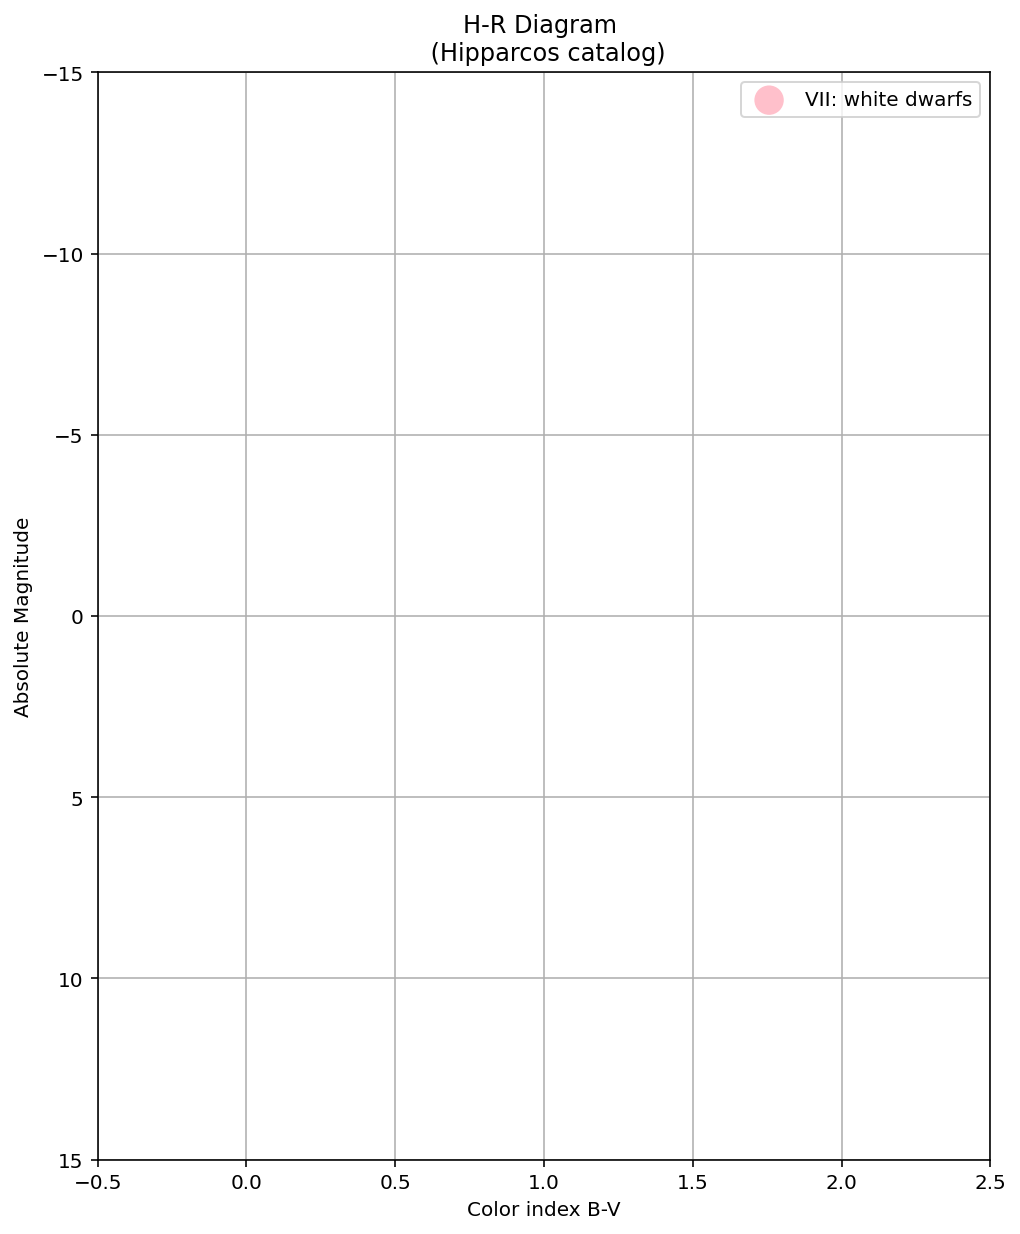

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [15]:
from matplotlib.animation import FFMpegWriter
metadata = dict(title='animation in 3D', artist='Matplotlib',comment='blah')
writer = FFMpegWriter(fps=15, metadata=metadata,bitrate=200000)

fig = plt.figure(figsize=(8,10))
ax = fig.add_subplot(111)


with writer.saving(fig, "animation1.mp4", dpi=200):
    x, y = [], []     

    for f in functions:
        if f == f1:
            c = "pink"
            name = "VII: white dwarfs"
        elif f == f2:
            c = "blue"
            name = "VI: subdwarfs"
        elif f == f3:
            c = "black"
            name = "V: main-sequence"
        elif f == f4:
            c = "grey"
            name = "IV: subgiants"
        elif f == f5:
            c = "green"
            name = "III: giants"
        elif f == f6:
            c = "orange"
            name = "II: bright giants"
        elif f == f7:
            c = "yellow"
            name = "I: supergiants"

        plot_lum_class(data4["SpType"].map(f), c, name)


        #fig.clear()
        ax = fig.add_subplot(111)
        ax.set_xlim(-0.5, 2.5)
        ax.set_ylim(15, -15)
        ax.grid()
        ax.set_title('H-R Diagram \n (Hipparcos catalog)')
        ax.set_xlabel('Color index B-V')
        ax.set_ylabel('Absolute Magnitude')
        legend = ax.legend(scatterpoints=1, markerscale = 6, shadow=False)

        plt.draw()
        plt.pause(0.01)
        writer.grab_frame()

In [16]:
import plotly.express as px
data5 = data3[:200]

In [17]:
fig = px.scatter(data5, x="B-V", y="M_V", animation_frame="class", animation_group="lum",
          size = "mass", color="class", hover_name="class",
           log_x=False, size_max = 55, range_x=[-.5, 2.5], range_y=[15,-15])
fig.write_html("file.html")